## Statistics and Results Notebook! ##

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [8]:
def ParseMetrics(fileName, dir):
    parsedData = {}
    
    fullPath = f"{dir}\{fileName}"
    
    df = pd.read_csv(fullPath)
    # print(df.head())
    # print(df.iloc[0]['Value'])
    
    # 1. Nodal Efficiency
    nodalString = df.iloc[0]['Value']
    valueDict = {}
    for item in nodalString.split(';'):
        if item.strip():  # Ignore empty strings
            key, val = item.split(':')
            valueDict[int(key.strip())] = float(val.strip())

    parsedData['Nodal Efficiency'] = valueDict
    
    # 2. Global Efficiency
    globalEfficiency = float(df.iloc[1]['Value'])
    parsedData['Global Efficiency'] = globalEfficiency
    
    # 3. Degree Centrality
    degreeCentralityString = df.iloc[2]['Value']
    degreeValueDict = {}
    for item in degreeCentralityString.split(';'):
        if item.strip():
            key, value = item.split(':')
            degreeValueDict[int(key.strip())] = float(value.strip())
    
    parsedData['Degree Centrality'] = degreeValueDict
    
    # 4. Average Clustering Coefficient
    averageClustering = float(float(df.iloc[5]['Value']))
    parsedData['Average Clustering'] = averageClustering
    
    return parsedData
    
    

<string>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\{'
<string>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\{'
C:\Users\mattm\AppData\Local\Temp\ipykernel_42812\2367837008.py:4: SyntaxWarning: invalid escape sequence '\{'
  fullPath = f"{dir}\{fileName}"


In [9]:
def ParsePhenotypicData(fileName, pathToPhenotypicCSV):
    phenotypicData = {}
    df = pd.read_csv(pathToPhenotypicCSV)
    
    
    resultRow = df[df['FILE_ID'] == fileName]
    
    if not resultRow.empty:
        # Define the columns you want to check and assign
        columns_to_check = ['FIQ', 'HANDEDNESS_CATEGORY', 'AGE_AT_SCAN', 'SEX']

        for col in columns_to_check:
            # Check if the value is NaN and handle accordingly
            if pd.isna(resultRow[col].values[0]):  # Check for NaN
                if col in ['FIQ', 'AGE_AT_SCAN', 'SEX']:  # Numeric columns
                    phenotypicData[col] = -9999
                else:  # Non numeric values 'empty'
                    phenotypicData[col] = "Unknown"
            else:
                if col in ['FIQ', 'AGE_AT_SCAN', 'SEX']:  # Numeric columns
                    phenotypicData[col] = float(resultRow[col].values[0])
                else:  # Non-numeric columns
                    phenotypicData[col] = resultRow[col].values[0]

        phenotypicData['DX_GROUP'] = resultRow['DX_GROUP'].values[0]
    return phenotypicData
    
    # print(df.head())

In [10]:
def FindNodesFromBrodmanns(ba_nums: list, pathToMapping):
    df = pd.read_csv(pathToMapping)
    print(df.head())
    
    results = {}
    for ba in ba_nums:
        
        matchingRows = df[df['ba.label'].str.extract(r'(\d+)')[0].astype(int) == ba]
        
        roiNums = matchingRows['ROI number'].tolist()
        results[ba] = roiNums
        
    return results

In [ ]:
import os
metricsDir =  R"C:\GIT\Connectomics\Research_Project\Binary_Notebooks\Binary_Output\10%\NetworkMetrics"
pathToPheno = R"C:\GIT\Connectomics\Research_Project\Phenotypic_V1_0b_preprocessed1.csv"

# strippedFileName = "Leuven_2_0050722"

fileNames = os.listdir(metricsDir)

columns = [
    "Node", "Participant", "IQ", "Age", "Handedness", "Sex", 
    "Nodal EFficiency", "Global Efficiency", "Average Clustering", "Degree Centrality"
]

results_df = pd.DataFrame(columns=columns)
dataframes = []

node = 83

ba_nums = [6, 7, 9, 10, 18, 19, 21, 37, 39, 40, 45, 46, 47]
pathToMap = R"C:\GIT\Connectomics\Research_Project\labeled_regions_ba.csv"

brodmannMapping = FindNodesFromBrodmanns(ba_nums, pathToMap) # Provides a mapping between ba: nodes that overlap

# results_df = results_df.append({'Node' : node})
# for each node in keys
for metricsFileName in fileNames:
    strippedFileName = metricsFileName.split('_rois')[0]
    
    metrics = ParseMetrics(metricsFileName, metricsDir)
    phenotypic = ParsePhenotypicData(strippedFileName, pathToPheno)
    
    # Validate Participant Based on Inclusion Criteria
    
    validParticipant = True
    for key, value in phenotypic.items():
        if value == -9999:
            validParticipant = False
            
        if value == "Unknown":
            validParticipant = False
            
    # if phenotypic['AGE_AT_SCAN'] < 18 or phenotypic['AGE_AT_SCAN'] > 45:
    #     validParticipant = False
    #     print("AGE RELEASED")
    
    # if phenotypic['HANDEDNESS_CATEGORY'] == -9999:
    #     validParticipant = False
    
    if metrics['Average Clustering'] == 0:
        validParticipant = False
        
    if validParticipant:
        
        temp_df = pd.DataFrame([{
            "Participant" : strippedFileName,
            "Node" : node,
            "DX_GROUP" : phenotypic.get("DX_GROUP", "N/A"),
            "IQ" : phenotypic.get("FIQ", "N/A"),
            "Age": phenotypic.get("AGE_AT_SCAN", "N/A"),
            "Handedness": phenotypic.get("HANDEDNESS_CATEGORY", "N/A"),
            "Sex": phenotypic.get("SEX", "N/A"),
            "Nodal Efficiency" : metrics.get("Nodal Efficiency")[node],
            "Global Eff": metrics.get("Global Efficiency", "N/A"),
            "Clustering": metrics.get("Average Clustering", "N/A"),
            "Degree Centrality": metrics.get("Nodal Efficiency")[node]
        }])
        dataframes.append(temp_df)
    else:
        print(f"Excluding Participant: {strippedFileName}")
        
        
results_df = pd.concat(dataframes, ignore_index=True)
results_df.to_csv("output_node83_age18-45.csv", index=False)

    



Excluding Participant: Caltech_0051469
Excluding Participant: Caltech_0051471
Excluding Participant: Caltech_0051473
Excluding Participant: Caltech_0051478
Excluding Participant: CMU_a_0050653
Excluding Participant: CMU_b_0050651
Excluding Participant: CMU_b_0050657
Excluding Participant: Leuven_2_0050722
Excluding Participant: Leuven_2_0050723
Excluding Participant: Leuven_2_0050724
Excluding Participant: Leuven_2_0050725
Excluding Participant: Leuven_2_0050726
Excluding Participant: Leuven_2_0050727
Excluding Participant: Leuven_2_0050728
Excluding Participant: Leuven_2_0050730
Excluding Participant: Leuven_2_0050731
Excluding Participant: Leuven_2_0050732
Excluding Participant: Leuven_2_0050733
Excluding Participant: Leuven_2_0050735
Excluding Participant: Leuven_2_0050736
Excluding Participant: Leuven_2_0050737
Excluding Participant: Leuven_2_0050738
Excluding Participant: Leuven_2_0050739
Excluding Participant: Leuven_2_0050740
Excluding Participant: Leuven_2_0050741
Excluding Par

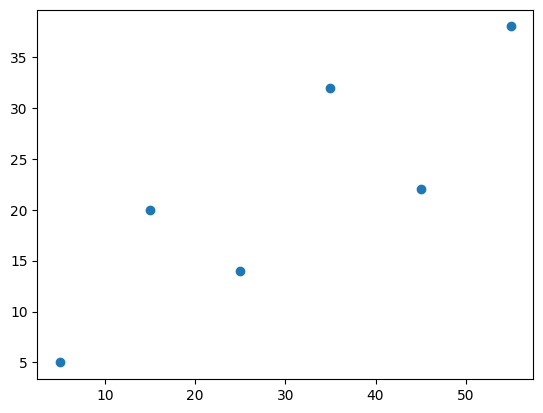

0.7158756137479542


In [11]:
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape(-1, 1)
y = np.array([5, 20, 14, 32, 22, 38])

import matplotlib.pyplot as plt

# PER NODE
# x --> fiq
# y --> degree centrality 
# covariates

# for each participant:
#   regression(x, y) <-- y is constant
#   store .score()

# NOTES:

# 1. Only include NT
# 2. Only include with recorded FSIQ, AGE, SEX, HANDEDNESS
# 3. (Double check 0.0 for all values)
# 4. 


plt.scatter(x, y)
plt.show()

model = LinearRegression()
model.fit(x, y)

r_sq = model.score(x, y)
print(r_sq)

## Linear Regression ##

571
317
Regression Coefficients:
IQ Coefficient: -0.00044742742087601256
Age Coefficient: -0.007689485563949212
Intercept: 0.4689514541886114
R-squared: 0.10081253642375942


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


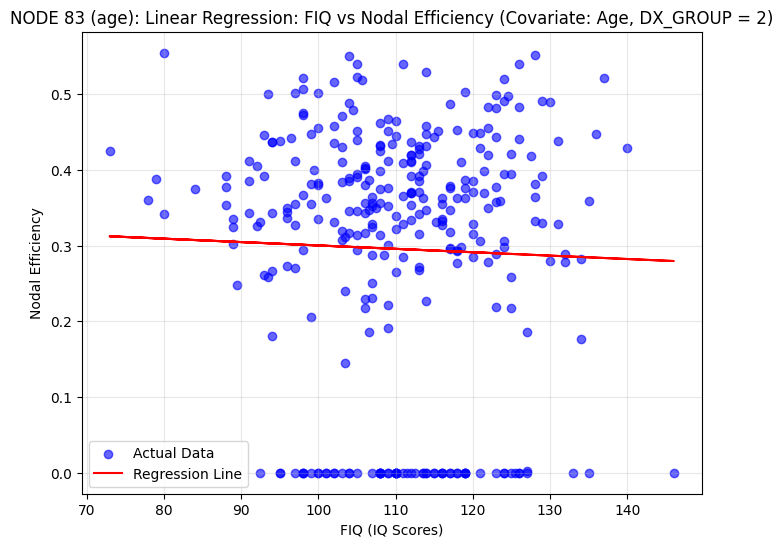

In [12]:
# Step 1: Load the data
file_path = "output_node83_age18-45.csv"  # Replace with your actual CSV file path
data = pd.read_csv(file_path)

print(len(data))

# Step 1.1: Filter data to include only DX_GROUP == 2
filtered_data = data[data['DX_GROUP'] == 2]

print(len(filtered_data))

# Step 2: Extract variables
X = filtered_data[['IQ', 'Age']]  # Independent variables (IQ and Age)
y = filtered_data['Nodal Efficiency']  # Dependent variable

# Step 3: Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 4: Get the regression coefficients
print("Regression Coefficients:")
print(f"IQ Coefficient: {model.coef_[0]}")
print(f"Age Coefficient: {model.coef_[1]}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {model.score(X, y)}")

# Step 5: Scatter plot and regression line
plt.figure(figsize=(8, 6))

# Scatter plot for FIQ vs Nodal Efficiency
plt.scatter(filtered_data['IQ'], y, color='blue', alpha=0.6, label="Actual Data")

# Predicted values for the regression line (keeping age constant at its mean)
age_mean = np.mean(filtered_data['Age'])  # Mean age
predicted_y = model.predict(np.column_stack((filtered_data['IQ'], [age_mean] * len(filtered_data))))

plt.plot(filtered_data['IQ'], predicted_y, color='red', label="Regression Line")

# Labels and title
plt.xlabel("FIQ (IQ Scores)")
plt.ylabel("Nodal Efficiency")
plt.title("NODE 83 (age): Linear Regression: FIQ vs Nodal Efficiency (Covariate: Age, DX_GROUP = 2)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
